In [1]:
from import_all import *

In [2]:
file_path1 = '../emg+dataset+in+lower+limb/SEMG_DB1/A_TXT/11Amar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])  # Ignore les 6 premières lignes
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX', 'Trash'], usecols=[0, 1, 2, 3, 4])
    
    data.dropna(inplace=True)
    data = data.astype(float)  # Convertir en float
    data['Time'] = data.index / 1000  # Ajout de la colonne temps
    return data

# Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)


data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])

data["FX"] = abs(data["FX"])  # Valeurs absolues pour FX

print(data.head())

         RF        BF        VM        ST    FX   Time
1 -0.000293 -0.001401  0.000134  0.004218  44.0  0.001
2 -0.000950 -0.003520 -0.011753 -0.031302  42.3  0.002
3 -0.001752 -0.000192 -0.011751 -0.024455  42.1  0.003
4 -0.000112 -0.000434 -0.010010  0.008959  41.9  0.004
5 -0.000136 -0.002825 -0.011056  0.048113  41.8  0.005


In [3]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = peaks[i] - shift_amount
    adjusted_peaks.append(adjusted_start)

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(f'Débuts de cycles ajustés : {adjusted_peaks}')

# Verification du premier cycle
print(len(adjusted_peaks))
for i in range(len(adjusted_peaks)):
    if adjusted_peaks[0] < 0 :
        adjusted_peaks.pop(0)
        print(f'Premier cycle supprimé : {adjusted_peaks}')
    else:
        print(f'Premier cycle valide : {adjusted_peaks}')
        break

cycle_lengths = np.diff(adjusted_peaks)
mean_cycle_length = np.mean(cycle_lengths)

# Calcul du temps moyen des cycles **normaux** (excluant les cycles corrompus)
normal_cycle_times = [t for t in cycle_lengths if t > 1000]
mean_normal_cycle_time = np.mean(normal_cycle_times)



print(f'Temps pour chaque cycle : {cycle_lengths}')
print(f'Temps moyen des cycles normaux : {mean_normal_cycle_time:.2f}')

#Détection et correction des cycles anormaux
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = (end_time - start_time)*1000


    if cycle_time >= 1.50 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Nombre de nouveaux cycles
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, divisé en {num_splits} cycles.')

        # Ajout des nouveaux débuts de cycle répartis uniformément
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'].iloc[1]*1000 - data['Time'].iloc[0]*1000))
            new_adjusted_peaks.append(new_peak)
    elif cycle_time <= 0.50 * mean_normal_cycle_time:
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, supprimé.')
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Ajout du dernier pic s'il n'a pas été traité
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Affichage des nouveaux débuts de cycles
print(f'Nouveaux débuts de cycles ajustés : {adjusted_peaks}')

# Début d'un nouveau cycle même si il n'y a pas de peak
if adjusted_peaks[-1]+int(np.mean(np.diff(adjusted_peaks))) < len(data):
    adjusted_peaks.append(adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))))
    print(f'Ajout d\'un début de nouveau cycle : {adjusted_peaks}')
else:
    print(f'Aucun nouveau cycle ajouté : {adjusted_peaks}')

# Suppression des 3 premiers et 3 derniers cycles si le nombre total de cycles est supérieur à 20
if len(adjusted_peaks) > 20:
    adjusted_peaks = adjusted_peaks[3:-3]
    print(f'Suppression des 3 premiers et 3 derniers cycles : {adjusted_peaks}')

Nombre de débuts de cycles ajustés : 34
Débuts de cycles ajustés : [663, 668, 2010, 3484, 3496, 5193, 6587, 6601, 7906, 9243, 10622, 13530, 14918, 16296, 16300, 17618, 17623, 17628, 17635, 19050, 19054, 19059, 19066, 22096, 22101, 22110, 23492, 23497, 23504, 24843, 24848, 24853, 26183, 26188]
34
Premier cycle valide : [663, 668, 2010, 3484, 3496, 5193, 6587, 6601, 7906, 9243, 10622, 13530, 14918, 16296, 16300, 17618, 17623, 17628, 17635, 19050, 19054, 19059, 19066, 22096, 22101, 22110, 23492, 23497, 23504, 24843, 24848, 24853, 26183, 26188]
Temps pour chaque cycle : [   5 1342 1474   12 1697 1394   14 1305 1337 1379 2908 1388 1378    4
 1318    5    5    7 1415    4    5    7 3030    5    9 1382    5    7
 1339    5    5 1330    5]
Temps moyen des cycles normaux : 1588.50
Cycle anormal détecté entre 0.66s et 0.67s, supprimé.
Cycle anormal détecté entre 3.48s et 3.50s, supprimé.
Cycle anormal détecté entre 6.59s et 6.60s, supprimé.
Cycle anormal détecté entre 10.62s et 13.53s, divisé en

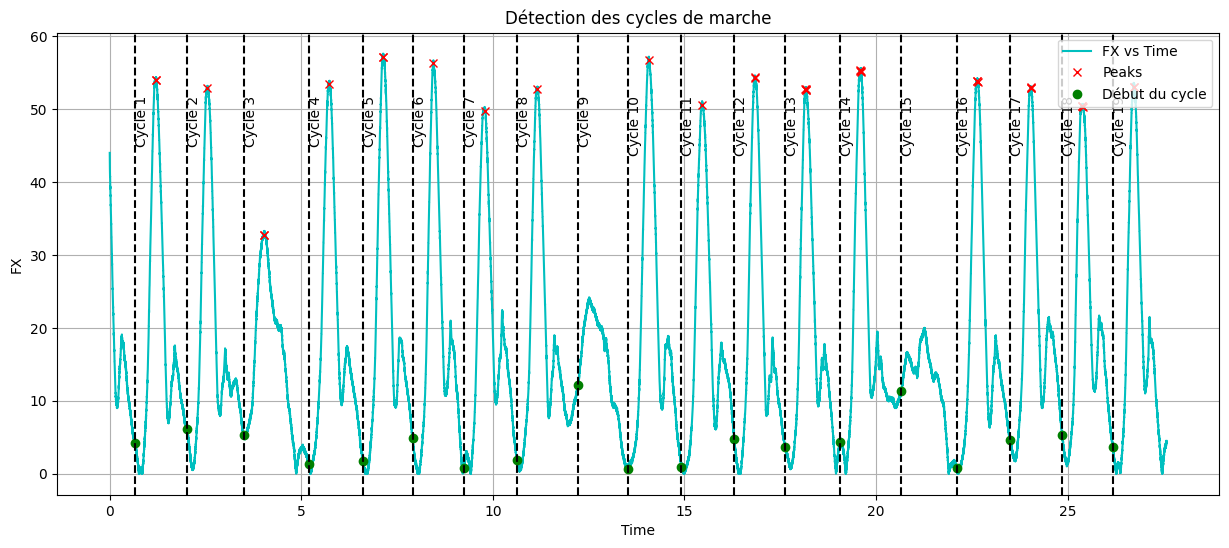

In [4]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# On calcul le temps de chaque cycle et on divise par la fréquence d'échantillonnage pour obtenir le temps en secondes
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Calcul du temps de cycle moyen
average_cycle_time = np.mean(cycle_durations)

print(f"Durée de chaque cycles (en secondes): {cycle_durations}")
print(f"Temps moyen de cycle (en secondes): {average_cycle_time}")

Durée de chaque cycles (en secondes): [1.342 1.486 1.697 1.408 1.305 1.337 1.379 1.588 1.32  1.388 1.382 1.335
 1.431 1.588 1.456 1.394 1.349 1.335]
Temps moyen de cycle (en secondes): 1.4177777777777778


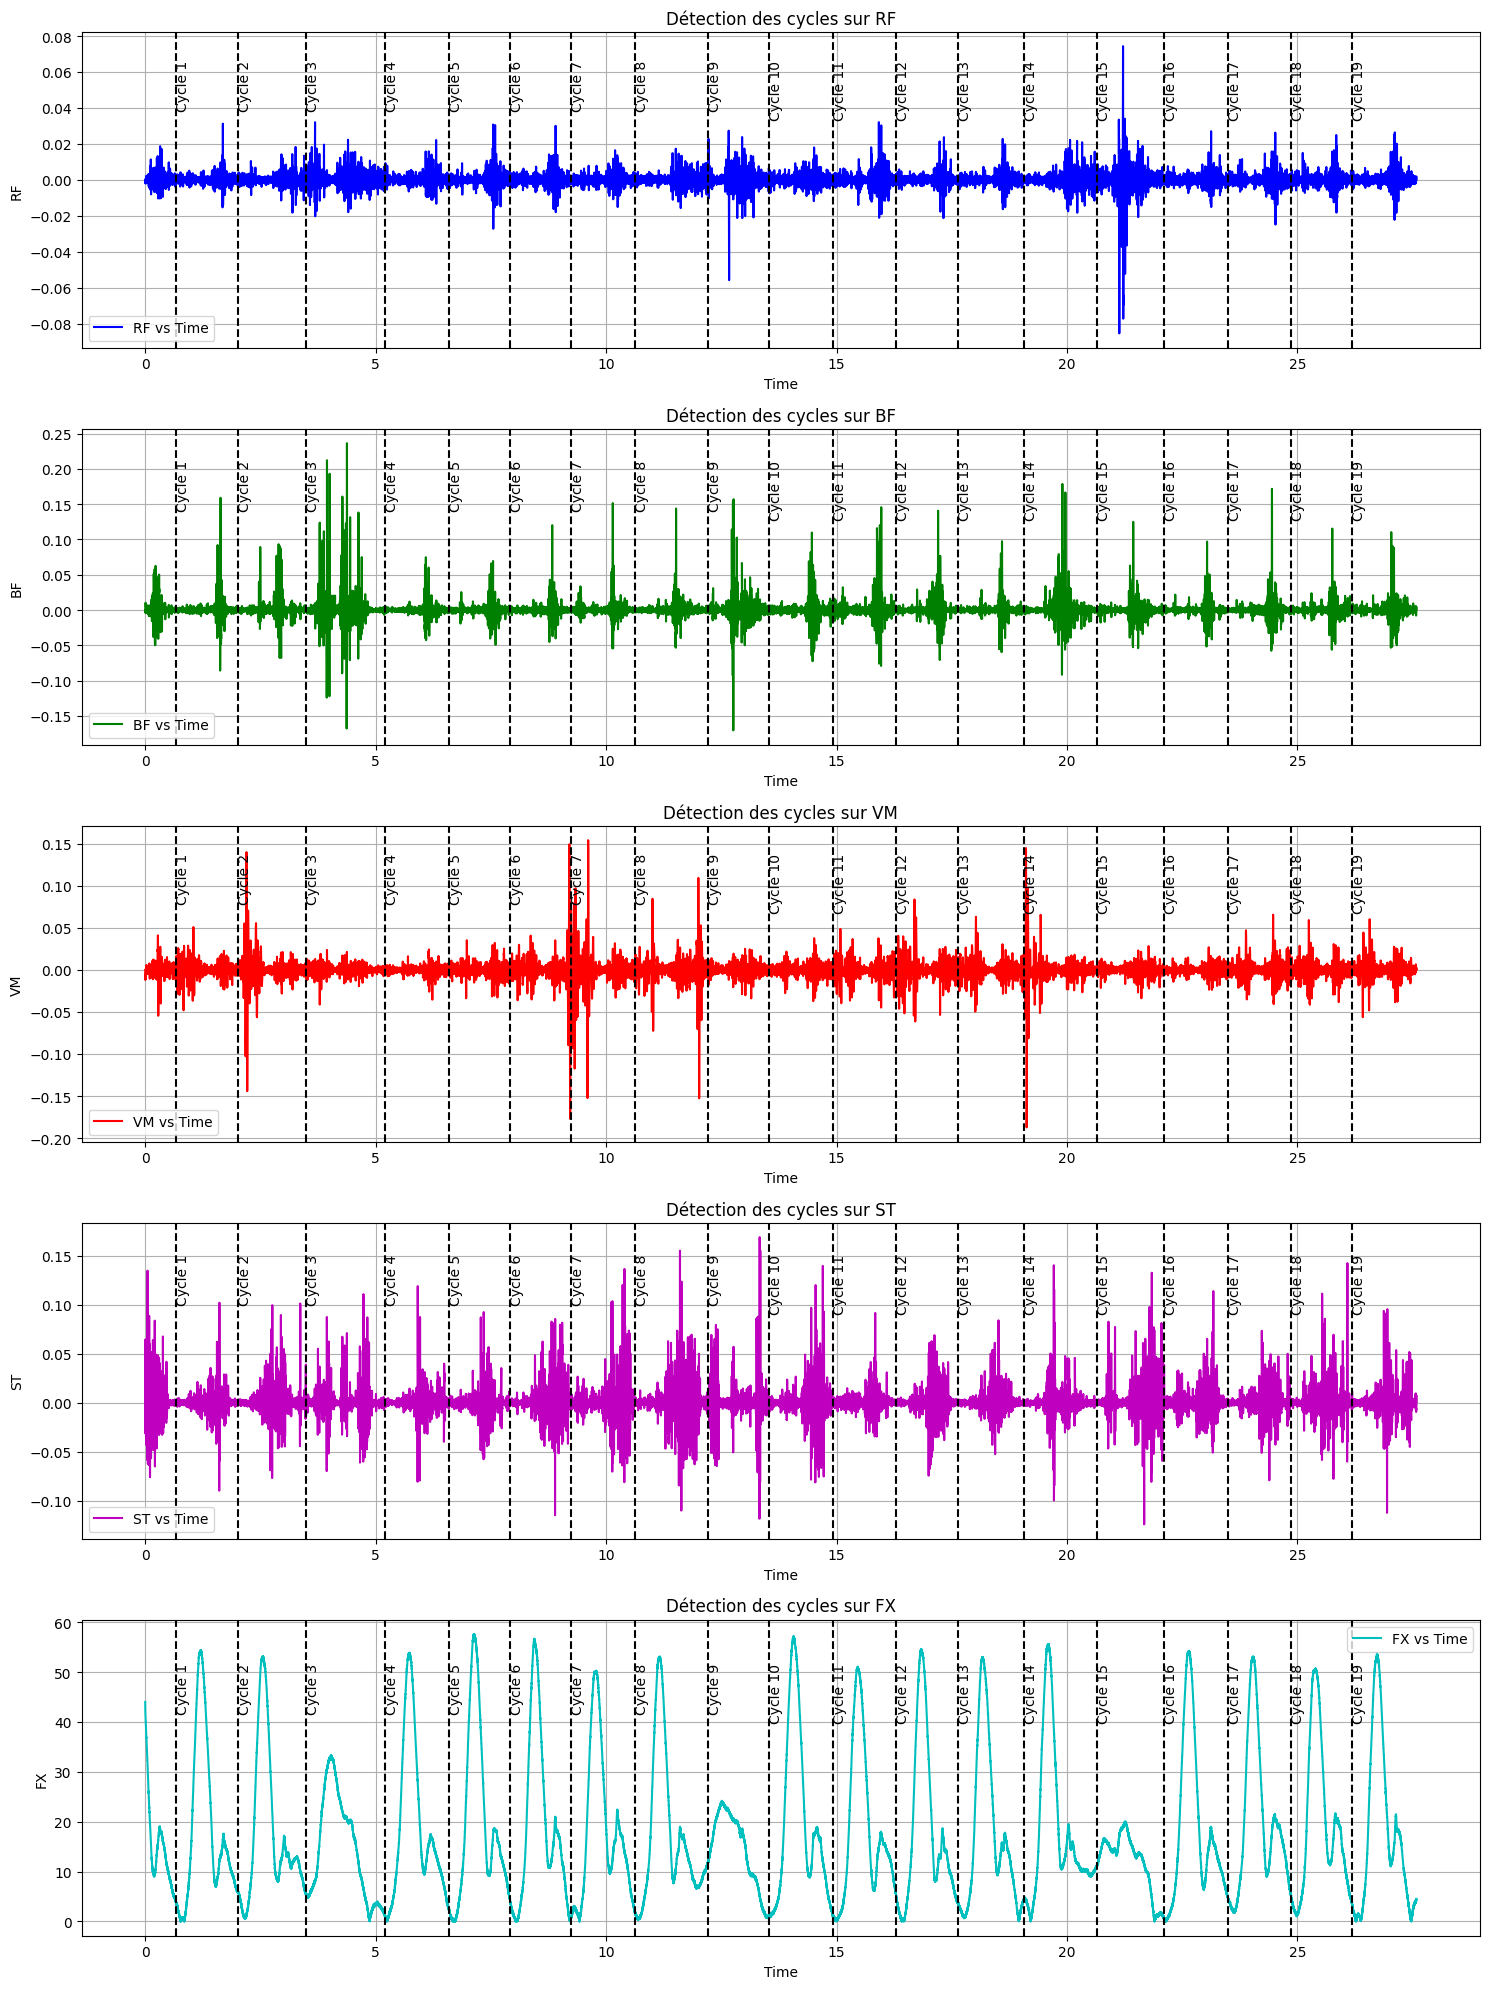

In [6]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) pour chaque cycle
rms_values_RF = []
rms_values_BF = []
rms_values_VM = []
rms_values_ST = []
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)


print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

mean_rms_RF = np.mean(rms_values_RF)
mean_rms_BF = np.mean(rms_values_BF)
mean_rms_VM = np.mean(rms_values_VM)
mean_rms_ST = np.mean(rms_values_ST)

print(f'Mean RMS RF: {mean_rms_RF:.4f}')
print(f'Mean RMS BF: {mean_rms_BF:.4f}')
print(f'Mean RMS VM: {mean_rms_VM:.4f}')
print(f'Mean RMS ST: {mean_rms_ST:.4f}')

[0.002618224782031008, 0.00275397194143791, 0.0044627598507629, 0.002903326537114421, 0.0038421362816264, 0.003292766974791651, 0.0027883567726389546, 0.0031085368058652793, 0.0053281307498084665, 0.002942324584621379, 0.004181006097443515, 0.0030067414112857935, 0.0028009702346042296, 0.0043372211065878345, 0.009280382564914324, 0.002930275037020708, 0.003575746561543116, 0.0033704159811384143]
[0.012160040838929938, 0.011191632039842456, 0.026131330182904384, 0.007685067543580574, 0.00854441450845828, 0.008767048024932726, 0.010266522691377964, 0.00887816920018938, 0.019384897978308765, 0.012738663741993188, 0.01558857328405304, 0.012637123026241221, 0.009252733217001565, 0.015280508610737629, 0.009627340748070146, 0.008711804132754184, 0.013071908560442635, 0.00898422109519947]
[0.01161630285659102, 0.023073815093959095, 0.005689296457907013, 0.0050386388483252675, 0.00867368972309527, 0.024777032750276685, 0.026784934096852772, 0.018973484748131788, 0.006599445208518625, 0.00773300

In [8]:
#Energie pour chaque cycle

energie_values_RF = []
energie_values_BF = []
energie_values_VM = []
energie_values_ST = []

for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    energie_RF = np.sum(np.square(data['RF'][start:end]))
    energie_values_RF.append(energie_RF)
    energie_BF = np.sum(np.square(data['BF'][start:end]))
    energie_values_BF.append(energie_BF)
    energie_VM = np.sum(np.square(data['VM'][start:end]))
    energie_values_VM.append(energie_VM)
    energie_ST = np.sum(np.square(data['ST'][start:end]))
    energie_values_ST.append(energie_ST)

print(energie_values_RF)
print(energie_values_BF)
print(energie_values_VM)
print(energie_values_ST)

mean_energie_RF = np.mean(energie_values_RF)
mean_energie_BF = np.mean(energie_values_BF)
mean_energie_VM = np.mean(energie_values_VM)
mean_energie_ST = np.mean(energie_values_ST)

print(f'Mean Energie RF: {mean_energie_RF:.4f}')
print(f'Mean Energie BF: {mean_energie_BF:.4f}')
print(f'Mean Energie VM: {mean_energie_VM:.4f}')
print(f'Mean Energie ST: {mean_energie_ST:.4f}')


[0.00919954555440185, 0.011270361120981752, 0.03379783464903148, 0.011868461413406844, 0.01926442462459987, 0.014496174286322437, 0.010721633284808187, 0.015344845704589553, 0.03747345001891199, 0.012016296258239112, 0.024158482165840316, 0.012069059375645083, 0.011226816419103726, 0.02987264124076043, 0.12539872880249733, 0.011969597438865876, 0.017248264724250627, 0.015165204687694146]
[0.19843696808036373, 0.18612540478482908, 1.1587903698661643, 0.08315685051434894, 0.09527416017651985, 0.10276333224256448, 0.14534865218998594, 0.12516915869533984, 0.4960220359108598, 0.22523569285702183, 0.33583099873862776, 0.21319533263777535, 0.12251230601054089, 0.37078838212368903, 0.13495036446448186, 0.10579837055897721, 0.23051009631356156, 0.10775616529771528]
[0.18108745633921197, 0.7911478012834589, 0.05492865583356272, 0.035746137072944426, 0.09817892590334969, 0.8207861075013749, 0.9893396858158171, 0.5716690800982923, 0.05748953371951605, 0.08300148367296661, 0.19810218973362448, 0.3

In [9]:
def calculate_variance(signal):
    N = len(signal)
    mean = np.mean(signal)
    variance = np.sum((signal - mean) ** 2) / (N - 1)
    return variance

# Calcul de la variance pour chaque muscle
var_RF = calculate_variance(data['RF'])
var_BF = calculate_variance(data['BF'])
var_VM = calculate_variance(data['VM'])
var_ST = calculate_variance(data['ST'])

# Affichage des résultats
print("Variance temporelle pour RF :", var_RF)
print("Variance temporelle pour BF :", var_BF)
print("Variance temporelle pour VM :", var_VM)
print("Variance temporelle pour ST :", var_ST)

Variance temporelle pour RF : 1.624993424622272e-05
Variance temporelle pour BF : 0.00017130108483785926
Variance temporelle pour VM : 0.00021524078223920338
Variance temporelle pour ST : 0.0001994138571582796


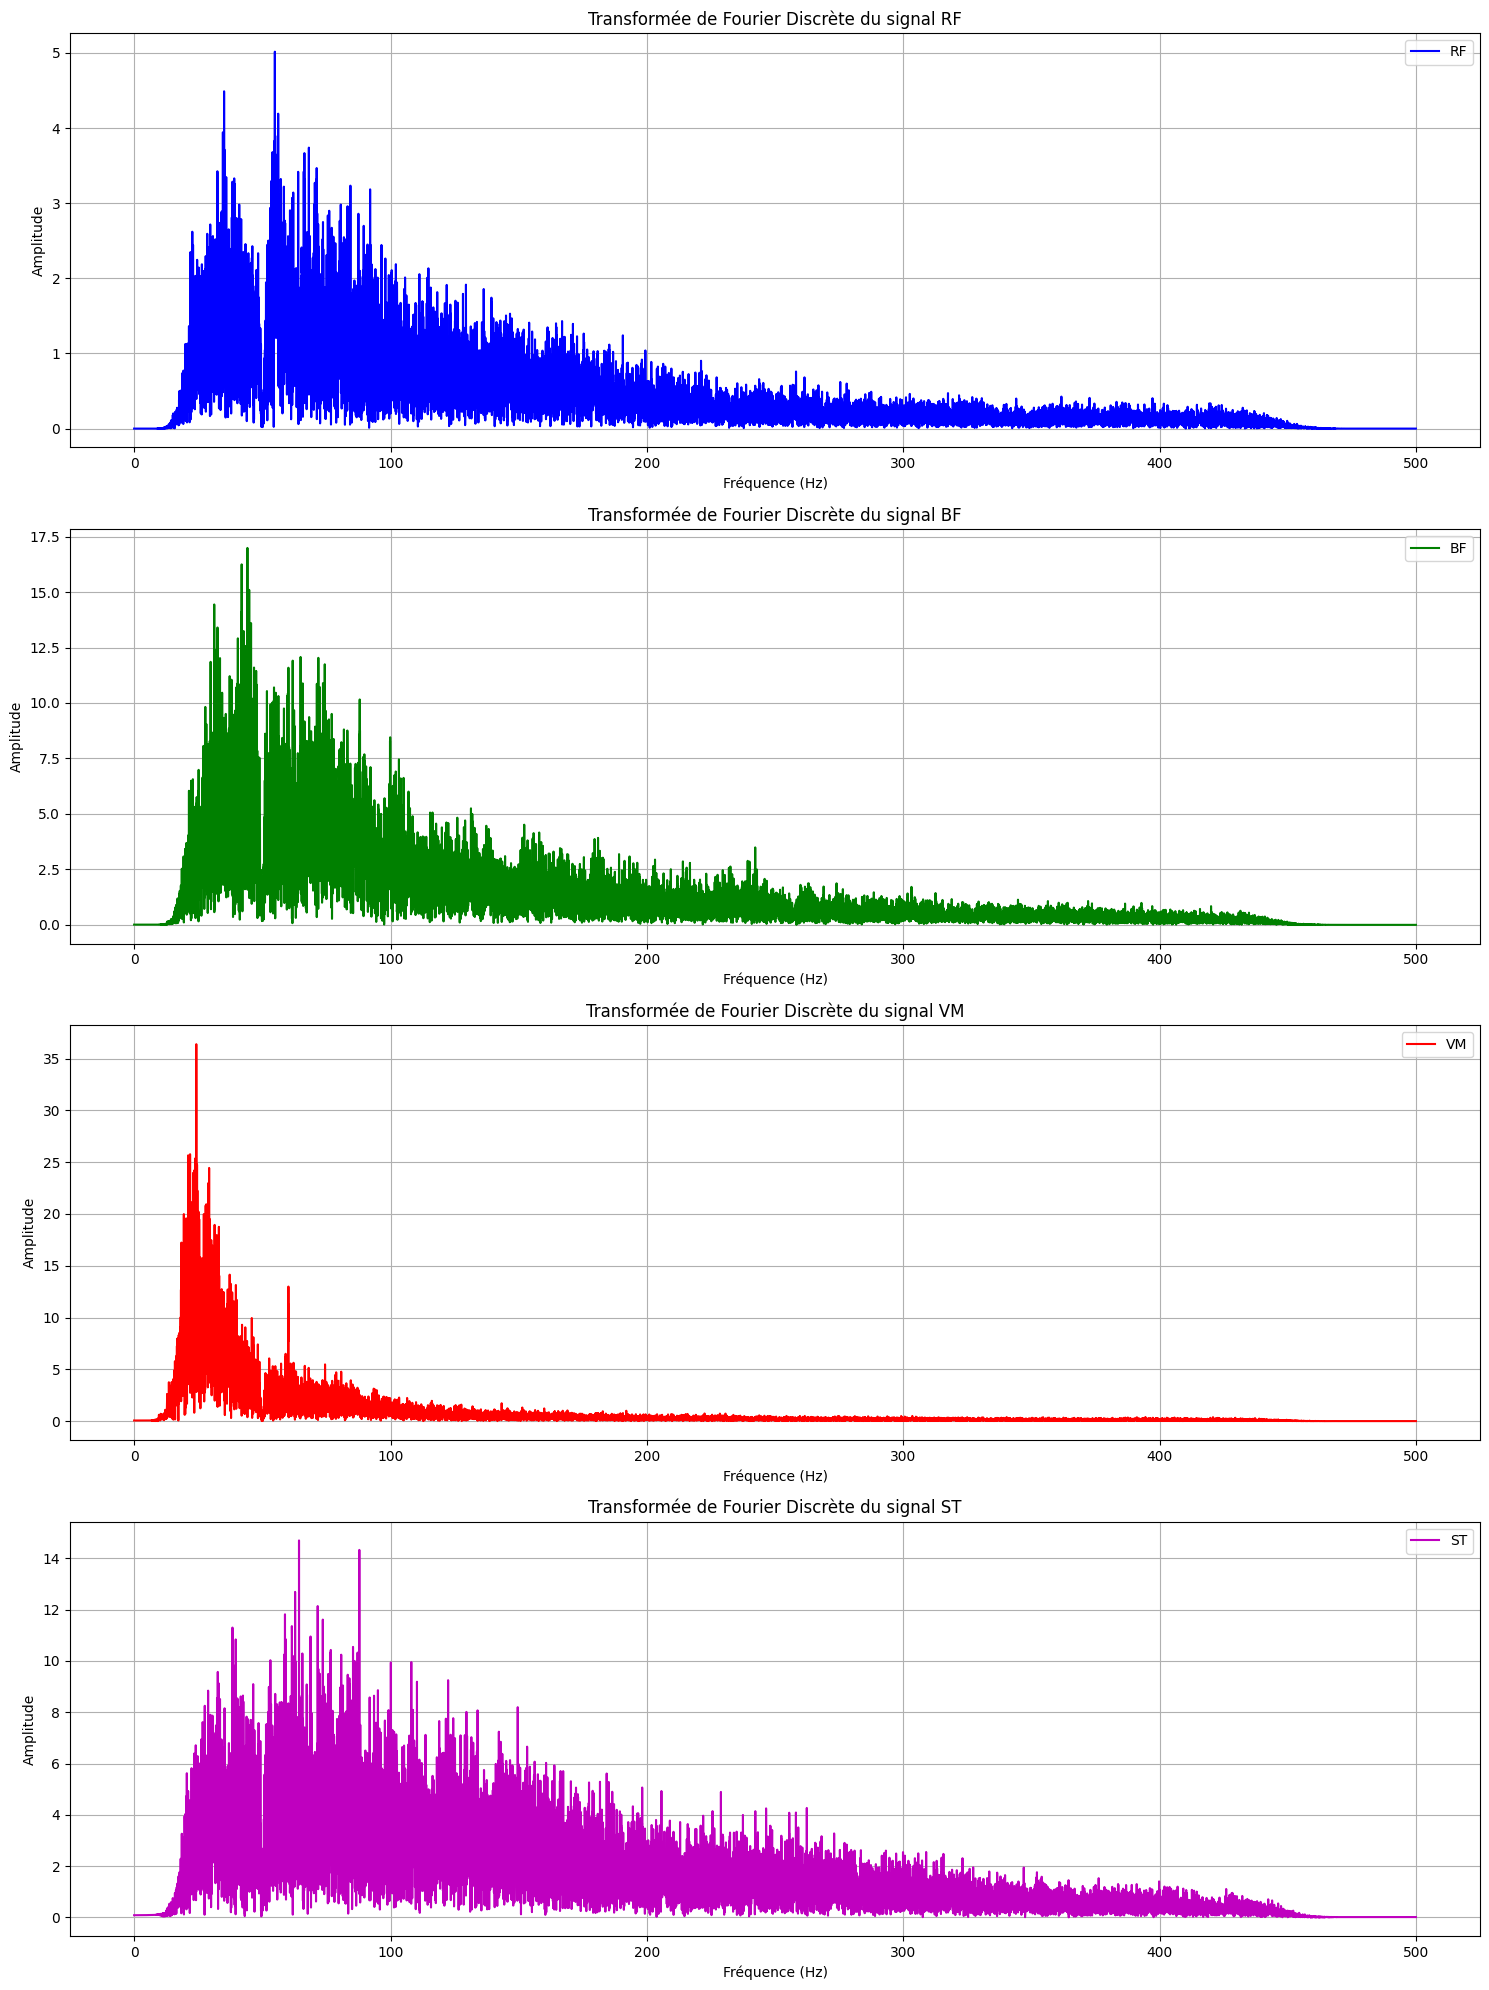

In [10]:
def transform_signal_to_frequency_domain(data, fs=1000):
    T = 1 / fs  # Période d'échantillonnage

    # Calcul de la Transformée de Fourier Discrète
    X = np.fft.fft(data)

    # Calcul des fréquences associées
    n = len(data)  # Nombre d'échantillons
    frequencies = np.fft.fftfreq(n, T)

    # Sélection des fréquences positives pour une meilleure visualisation
    positive_frequencies = frequencies[:n // 2]
    positive_X = X[:n // 2]

    # Calcul de l'amplitude du signal fréquentiel
    amplitude = np.abs(positive_X)

    return positive_frequencies, amplitude

# Transformation des signaux en domaine fréquentiel
frequencies, amplitude_RF = transform_signal_to_frequency_domain(data['RF'])
_, amplitude_BF = transform_signal_to_frequency_domain(data['BF'])
_, amplitude_VM = transform_signal_to_frequency_domain(data['VM'])
_, amplitude_ST = transform_signal_to_frequency_domain(data['ST'])

# Affichage des signaux en domaine fréquentiel sur des graphiques séparés
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

axs[0].plot(frequencies, amplitude_RF, label='RF', color='b')
axs[0].set_xlabel('Fréquence (Hz)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Transformée de Fourier Discrète du signal RF')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(frequencies, amplitude_BF, label='BF', color='g')
axs[1].set_xlabel('Fréquence (Hz)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Transformée de Fourier Discrète du signal BF')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(frequencies, amplitude_VM, label='VM', color='r')
axs[2].set_xlabel('Fréquence (Hz)')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Transformée de Fourier Discrète du signal VM')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(frequencies, amplitude_ST, label='ST', color='m')
axs[3].set_xlabel('Fréquence (Hz)')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Transformée de Fourier Discrète du signal ST')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Convertir les valeurs des pics en entiers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# Initialisation des listes pour stocker les Mean Frequency (MF) par cycle
mf_values_RF = []
mf_values_BF = []
mf_values_VM = []
mf_values_ST = []

# Calcul de la puissance du signal fréquentiel
power_RF = amplitude_RF ** 2
power_BF = amplitude_BF ** 2
power_VM = amplitude_VM ** 2
power_ST = amplitude_ST ** 2

# Calcul de la Mean Frequency (MF) pour chaque muscle
mf_RF = np.sum(frequencies * power_RF) / np.sum(power_RF)
mf_BF = np.sum(frequencies * power_BF) / np.sum(power_BF)
mf_VM = np.sum(frequencies * power_VM) / np.sum(power_VM)
mf_ST = np.sum(frequencies * power_ST) / np.sum(power_ST)

# Affichage des résultats
print("MF pour RF :", mf_RF)
print("MF pour BF :", mf_BF)
print("MF pour VM :", mf_VM)
print("MF pour ST :", mf_ST)


MF pour RF : 87.71138127830996
MF pour BF : 79.92824409840206
MF pour VM : 32.65978368766796
MF pour ST : 109.86791546188503


In [12]:
def calcul_mdf(frequencies, power):
    cumulative_power = np.cumsum(power)
    total_power = cumulative_power[-1]
    half_power = total_power / 2

    # Trouver l'indice où la puissance cumulée dépasse la moitié
    idx = np.where(cumulative_power >= half_power)[0][0]

    # Fréquence correspondante
    return frequencies[idx]

# Calcul des Median Frequencies (MDF)
mdf_RF = calcul_mdf(frequencies, power_RF)
mdf_BF = calcul_mdf(frequencies, power_BF)
mdf_VM = calcul_mdf(frequencies, power_VM)
mdf_ST = calcul_mdf(frequencies, power_ST)

# Affichage des résultats
print("MDF pour RF :", mdf_RF)
print("MDF pour BF :", mdf_BF)
print("MDF pour VM :", mdf_VM)
print("MDF pour ST :", mdf_ST)

MDF pour RF : 71.05826052278577
MDF pour BF : 65.83765362723416
MDF pour VM : 26.429322408730012
MDF pour ST : 89.9467063046079


In [13]:
def calculate_spectral_entropy(power):
    # Normalisation des puissances pour obtenir P(f_k)
    power_sum = np.sum(power)
    if power_sum == 0:
        return 0  # Évite une division par zéro
    P = power / power_sum

    # Suppression des 0 pour éviter log(0)
    P_nonzero = P[P > 0]

    # Entropie spectrale
    entropy = -np.sum(P_nonzero * np.log(P_nonzero))
    return entropy

# Calcul de l'entropie spectrale pour chaque muscle
se_RF = calculate_spectral_entropy(power_RF)
se_BF = calculate_spectral_entropy(power_BF)
se_VM = calculate_spectral_entropy(power_VM)
se_ST = calculate_spectral_entropy(power_ST)

# Affichage des résultats
print("Spectral Entropy pour RF :", se_RF)
print("Spectral Entropy pour BF :", se_BF)
print("Spectral Entropy pour VM :", se_VM)
print("Spectral Entropy pour ST :", se_ST)

Spectral Entropy pour RF : 8.031416893007746
Spectral Entropy pour BF : 7.893401843914746
Spectral Entropy pour VM : 6.561214130989011
Spectral Entropy pour ST : 8.33027590673341
